In [1]:
# Import dependencies
from skimage import io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
train_volume = io.imread('Data/train-volume.tif')
train_labels = io.imread('Data/train-labels.tif')
test_volume = io.imread('Data/test-volume.tif')

In [3]:
def normalize(x):
    x = x.astype(np.float32)
    x /=255
    return x

In [4]:
# Preprocess data
train_volume = normalize(train_volume)
train_labels = normalize(train_labels)
test_volume = normalize(test_volume)

In [5]:
# Create batches

# The data is currently a multidimensional numpy array (ndarray) with 3 dimensions. It has the shape 30 * 512 * 512, which
# means that the data exists of 30 greyscale pictures with dimension 512 pixels on 512 pixels. We want to make 30 batches of 1 
# picture each.

def get_batches(data):
    data = np.split(data, 30)
    data = np.swapaxes(data, 1, 2)
    data = np.swapaxes(data, 2, 3)
    return data

In [6]:
volume_batches = get_batches(train_volume)
labels_batches = get_batches(train_labels)
test_batches = get_batches(test_volume)

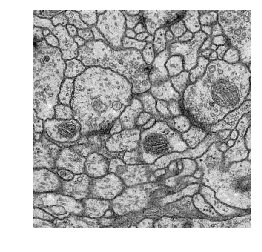

In [7]:
%matplotlib inline
plt.axis('off')
plt.imshow(volume_batches[1].reshape(512,512), cmap='Greys_r')

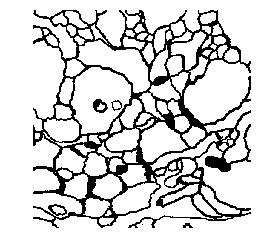

In [8]:
%matplotlib inline
plt.axis('off')
plt.imshow(labels_batches[1].reshape(512,512), cmap='Greys_r')

In [9]:
# Construct a convolutional autoencoder

# Create placeholders
x = tf.placeholder(dtype = tf.float32, shape=(None, 512, 512, 1), name='x')
y = tf.placeholder(dtype = tf.float32, shape=(None, 512, 512, 1), name='y')

### Encoder
conv1 = tf.layers.conv2d(x, 32, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 512x512x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), padding='same')
# Now 256x256x32
conv2 = tf.layers.conv2d(maxpool1, 64, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 256x256x64
maxpool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), padding='same')
# Now 128x128x64
conv3 = tf.layers.conv2d(maxpool2, 128, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 128x128x128
maxpool3 = tf.layers.max_pooling2d(conv3, (2, 2), (2, 2), padding='same')
# Now 64x64x128
conv4 = tf.layers.conv2d(maxpool3, 256, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 64x64x256
    
encoded = tf.layers.max_pooling2d(conv4, (2, 2), (2, 2), padding='same')
# Now 32x32x256
    
### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (64,64))
# Now 64x64x256
conv5 = tf.layers.conv2d(upsample1, 256, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 64x64x256
upsample2 = tf.image.resize_nearest_neighbor(conv5, (128,128))
# Now 128x128x256
conv6 = tf.layers.conv2d(upsample2, 128, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 128x128x128
upsample3 = tf.image.resize_nearest_neighbor(conv6, (256,256))
# Now 256x256x128
conv7 = tf.layers.conv2d(upsample3, 64, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 256x256x64
upsample4 = tf.image.resize_nearest_neighbor(conv7, (512,512))
# Now 512x512x64
conv8 = tf.layers.conv2d(upsample4, 32, (3,3), strides=(1,1), padding='same', activation=tf.nn.relu)
# Now 512x512x32
    
logits = tf.layers.conv2d(conv8, 1, (3,3), strides=(1,1), padding='same', activation=None)
# Now 512x512x1
    
decoded = tf.sigmoid(logits, name='decoded')

# Loss and Optimizer
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
cost = tf.reduce_mean(loss)
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

AttributeError: module 'tensorflow' has no attribute 'layers'

In [38]:
# Train the Neural Network
def train_neural_network(session, optimizer, feature_batch, label_batch):
    session.run(optimizer, feed_dict = {x: feature_batch, y: label_batch})

In [39]:
# Show Stats
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    print("cost: ", session.run(cost, feed_dict = {x: feature_batch, y: label_batch}))
    print("accuracy: ", session.run(accuracy, feed_dict =  {x: valid_features, y: valid_labels}))

In [33]:
# Hyperparameters
epochs = 10
batch_size = 1

In [34]:
# Train Model
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        for i in range(len(train_volume)):
            train_neural_network(sess, optimizer, volume_batches, labels_batches)
            print_stats(sess, volume_batches[i], labels_batches[i], cost, accuracy)

ValueError: Cannot feed value of shape (512, 512, 1) for Tensor 'x_3:0', which has shape '(?, 512, 512, 1)'